In [193]:
# general libraries
import numpy as np
import pandas as pd

# torch libraries
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

### Datasets

In [194]:
# reading the dataset
movies = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python')
users = pd.read_csv('ml-1m/users.dat', sep='::', header=None, engine='python')
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python')

In [195]:
movies.columns = ['MovieID', 'Title', 'Genres']
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [196]:
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [197]:
users.columns = ["UserID", "Gender", "Age", "Occupation", "Zip"]
users.head()

,UserID,Gender,Age,Occupation,Zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### Training and Testing Data Split

In [198]:
training_set, testing_set = train_test_split(ratings, train_size=0.75)

In [199]:
print(training_set.shape)
print(testing_set.shape)

(750156, 4)
(250053, 4)


In [200]:
# row:-  userId :: movieId :: rating(0-5) :: timestamp
training_set.head()

,UserID,MovieID,Rating,Timestamp
787237,4708,32,4,963513901
977690,5890,3608,4,957471449
544467,3356,1997,5,967697436
677493,4060,2302,4,965491773
696509,4169,2531,3,967164813


In [201]:
# row:-  userId :: movieId :: rating(0-5) :: timestamp
testing_set.head()

,UserID,MovieID,Rating,Timestamp
42380,289,745,5,976566826
774880,4621,1092,4,964118983
892920,5394,2858,5,960319179
829897,4982,1097,5,962595672
345355,2025,70,1,974672237


In [202]:
# get the maximum id of movies-id
max_movie_id = max (ratings.iloc[:, 1])
print(max_movie_id)

3952


In [203]:
# get the maximum id of the userID
max_user_id = max (ratings.iloc[:, 0])
print(max_user_id)

6040


### transforming the data

In [204]:
# transforming the training data
train_data = []

for i in range(1, max_user_id+1):
    
    movies_lst = training_set.iloc[:,1][training_set.iloc[:, 0] == i]
    rating_lst = training_set.iloc[:,2][training_set.iloc[:, 0] == i]
    new_lst = np.zeros(max_movie_id)
    new_lst[movies_lst-1] = rating_lst   
    train_data.append(new_lst)
    

In [205]:
# transforming the testing data
test_data = []

for i in range(1, max_user_id+1):
    
    movies_lst = testing_set.iloc[:,1][testing_set.iloc[:, 0] == i]
    rating_lst = testing_set.iloc[:,2][testing_set.iloc[:, 0] == i]
    new_lst = np.zeros(max_movie_id)
    new_lst[movies_lst-1] = rating_lst   
    test_data.append(new_lst)

In [206]:
print(len(train_data))
print(len(train_data[0]))

6040
3952


In [207]:
print(len(test_data))
print(len(test_data[0]))

6040
3952


In [208]:
# convert the data to tensor
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

In [209]:
com_test_data = test_data
com_train_data = train_data

In [210]:
# converting the ratings to binary as RBM works on binary set only
train_data[train_data == 0] = -1 # no rating
train_data[train_data == 1] = 0  # bad movie
train_data[train_data == 2] = 0 # bad movie
train_data[train_data > 2] = 1 # good movie


test_data[test_data == 0] = -1 # no rating
test_data[test_data == 1] = 0  # bad movie
test_data[test_data == 2] = 0 # bad movie
test_data[test_data > 2] = 1  # good movie 

### Model

In [211]:
'''
GenerativeModels H. G.M.
Github repository
'''
class RBM:
    def __init__(self, num_visible, num_hidden):
        #self.num_visible = num_visible
        #self.num_hidden = num_hidden
        
        # initialize the weights with random
        self.W = torch.randn(num_hidden, num_visible)
        self.a = torch.randn(1, num_hidden)
        self.b = torch.randn(1, num_visible)
        print(self.W)
        
        
    def sample_hidden(self, x):
        Wx = torch.mm(x, self.W.t())  
        activation = Wx + self.a.expand_as(Wx)
        ph_given_v = torch.sigmoid(activation)
        return ph_given_v, torch.bernoulli(ph_given_v)
    
    
    def sample_visible(self, y):
        Wy = torch.mm(y, self.W)
        activation = Wy + self.b.expand_as(Wy)
        pv_given_h = torch.sigmoid(activation)
        return pv_given_h, torch.bernoulli(pv_given_h)
    
    def train (self, v0, vk, ph0, phk):
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).t()
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0-phk), 0)


nv = len(train_data[0])
nh= 100
batch_size = 100
rbm = RBM(nv, nh)

### Training

In [213]:

nb_epoch = 20
rmse_erros = []
for epoch in range(1, nb_epoch+1):
    train_loss = 0
    s = 0.
    for id_user in range(0, max_user_id - batch_size, 100):
        vk = train_data[id_user: id_user+batch_size]
        v0 = train_data[id_user: id_user+batch_size]
        ph0, _ = rbm.sample_hidden(v0)
        for k in range(10):
            _, hk = rbm.sample_hidden(vk)
            _, vk = rbm.sample_visible(hk)
            vk[v0<0] = v0[v0<0]
        phk, _ = rbm.sample_hidden(vk)
        rbm.train(v0, vk, ph0, phk)
        train_loss += torch.mean(torch.abs(v0[v0>=0]-vk[v0>=0])**2)
        s += 1
    print('epoch: '+str(epoch)+'RMSE Reconstruction loss: '+str(train_loss/s))
    rmse_erros.append(train_loss/s)


epoch: 1RMSE Reconstruction loss: tensor(0.2423)
epoch: 2RMSE Reconstruction loss: tensor(0.2286)
epoch: 3RMSE Reconstruction loss: tensor(0.2281)
epoch: 4RMSE Reconstruction loss: tensor(0.2295)
epoch: 5RMSE Reconstruction loss: tensor(0.2283)
epoch: 6RMSE Reconstruction loss: tensor(0.2287)
epoch: 7RMSE Reconstruction loss: tensor(0.2282)
epoch: 8RMSE Reconstruction loss: tensor(0.2281)
epoch: 9RMSE Reconstruction loss: tensor(0.2278)
epoch: 10RMSE Reconstruction loss: tensor(0.2283)
epoch: 11RMSE Reconstruction loss: tensor(0.2279)
epoch: 12RMSE Reconstruction loss: tensor(0.2283)
epoch: 13RMSE Reconstruction loss: tensor(0.2279)
epoch: 14RMSE Reconstruction loss: tensor(0.2283)
epoch: 15RMSE Reconstruction loss: tensor(0.2279)
epoch: 16RMSE Reconstruction loss: tensor(0.2278)
epoch: 17RMSE Reconstruction loss: tensor(0.2283)
epoch: 18RMSE Reconstruction loss: tensor(0.2283)
epoch: 19RMSE Reconstruction loss: tensor(0.2284)
epoch: 20RMSE Reconstruction loss: tensor(0.2281)


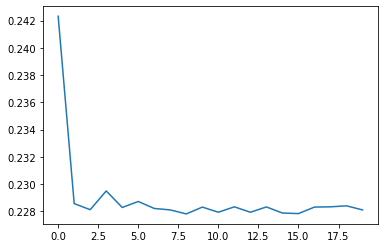

In [214]:
# plotting the reconstruction error
import matplotlib.pyplot as plt
plt.xlabel = 'epochs'
plt.ylabel = 'RMSE error'
plt.plot(list(range(20)), rmse_erros, "-")

### Testing

In [215]:
test_loss = 0
movies_like = torch.FloatTensor()
print(movies_like.shape)
s = 0.
for id_user in range(0, max_user_id):
    v_input = train_data[id_user: id_user+1]
    v_target = test_data[id_user: id_user+1]
    if len(v_target[v_target>=0]):
        _, h = rbm.sample_hidden(v_input)
        _, v_input = rbm.sample_visible(h)
        test_loss += torch.mean(torch.abs(v_target[v_target>=0]-v_input[v_target>=0])**2)    
        s += 1
        
print(movies_like.shape)

torch.Size([0])
torch.Size([0])


In [216]:
print('test Reconstruction loss: ' +str(test_loss/s))

test Reconstruction loss: tensor(0.2101)


### SVD

In [217]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [218]:
movies = pd.read_csv('ml-1m/movies.dat', sep='::', header=None, engine='python')
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python')
users = pd.read_csv('ml-1m/users.dat', sep='::', header=None, engine='python')

In [219]:
rating_data = []

for i in range(1, max_user_id+1):
    
    movies_lst = ratings.iloc[:,1][ratings.iloc[:, 0] == i]
    rating_lst = ratings.iloc[:,2][ratings.iloc[:, 0] == i]
    new_lst = np.zeros(max_movie_id)
    new_lst[movies_lst-1] = rating_lst   
    rating_data.append(new_lst)
    
print(len(rating_data))

6040


In [220]:
print(len(rating_data))
print(len(rating_data[0]))

6040
3952


In [221]:
# perform SVD
from sklearn.decomposition import TruncatedSVD

train = rating_data[:4000][:3000]
test = rating_data[4000:][3000:]

train = np.array(train)
test = np.array(test)

movie_svd = TruncatedSVD(n_components=10)
movie_features = movie_svd.fit_transform(train.transpose())

user_svd = TruncatedSVD(n_components=10)
user_features = user_svd.fit_transform(train)



In [222]:
print(movie_features.shape)
print(user_features.shape)

(3952, 10)
(3000, 10)


In [223]:
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python')

In [224]:
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [225]:
ratings['UserID'] = ratings['UserID'].apply(lambda x:x-1)
ratings['MovieID'] = ratings['MovieID'].apply(lambda x:x-1)

In [226]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,0,1192,5,978300760
1,0,660,3,978302109
2,0,913,3,978301968
3,0,3407,4,978300275
4,0,2354,5,978824291


In [227]:
columns = ["uf{0}".format(i+1) for i in range(10)]
ufs = pd.DataFrame(user_features, columns = columns)
ufs["UserID"] = ufs.index


columns = ["mf{0}".format(i+1) for i in range(10)]
mfs = pd.DataFrame(movie_features, columns = columns)
mfs["MovieID"] = mfs.index


train_data = ratings.merge(ufs, on="UserID") \
    .merge(mfs, on="MovieID") \
    .drop(["UserID", "MovieID"], axis = 1)


In [228]:
import numpy as np

targets = np.array(train_data.Rating)
data = np.array(train_data.drop("Rating", axis = 1))

print ("targets.shape = {0}".format(targets.shape))
print ("data.shape = {0}".format(data.shape))

targets.shape = (487756,)
data.shape = (487756, 21)


In [229]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error 
import math

regressor = GradientBoostingRegressor(learning_rate=0.1, n_estimators=20, verbose=1)
regressor.fit(data, targets)

print (math.sqrt(mean_squared_error( regressor.predict(data), targets )))
print(regressor.score)

      Iter       Train Loss   Remaining Time 
         1           1.2097           36.60s
         2           1.1777           35.06s
         3           1.1508           32.67s
         4           1.1288           30.69s
         5           1.1110           28.73s
         6           1.0938           26.67s
         7           1.0812           24.64s
         8           1.0691           22.80s
         9           1.0596           20.90s
        10           1.0510           19.01s
        20           1.0081            0.00s
1.004036671961733
<bound method RegressorMixin.score of GradientBoostingRegressor(n_estimators=20, verbose=1)>


In [ ]:
# fine-tuning using cross-validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, targets,
                         scoring="neg_mean_squared_error", cv=20)
tree_rmse_scores = np.sqrt(-scores)

In [231]:
scores = list(tree_rmse_scores)
scores.reverse()
print(scores)

[1.1051987172263587, 1.0562585540009581, 1.0736926859111169, 0.9835784869894509, 0.9979154917554774, 1.0373242399645226, 1.0677663883737964, 1.0483830138662726, 1.0454991097166006, 0.9969956779669001, 1.005763506758677, 0.9954811775681123, 1.0118134553075917, 0.9965306329599669, 0.985732515535996, 0.9620059361612778, 0.9660947815748512, 0.9614966497555344, 0.946004456652477, 0.9333136500196226]


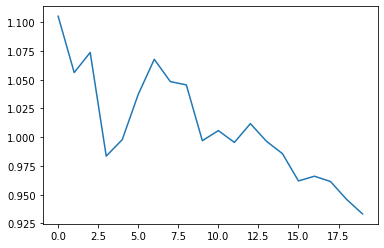

In [233]:
import matplotlib.pyplot as plt
plt.xlabel = 'epochs'
plt.ylabel = 'RMSE error'
plt.plot(list(range(20)), scores, "-")